In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import datetime
import time
import sys
import os
import tables

pd.set_option('display.max_columns', None)

ModuleNotFoundError: No module named 'matplotlib'

In [3]:
# !pip install tables
# !pip install bs4

# Load custom modules

These are downloaded to the Github repo from the MSD website. The original code was written in python 2, so some minor updates are needed to ensure they run in python 3.

Clone the repo and add the directory that the python source files are saved in to your system path so that they can be imported. 

In [4]:
# Check current working directory
os.getcwd()

'/Users/gena/Documents/GitHub/CS109B_MSD/notebooks/EDA'

In [5]:
# Add MSD source code to your sys path so that the imports will work
# Change to wherever the github repo is cloned and point to the folder with the python source code from the repo 'PythronSrc'
sys.path.append('/Users/gena/Documents/GitHub/CS109B_MSD/MSongsDB_code/PythonSrc/')

# Use the code saved in github rather than the original from the labROSA website
# The report version has edits to switch from python 2 to python 3 (more may be needed if we use other modules)
import hdf5_getters as GETTERS
import hdf5_utils as HDF5

need pg module and MBrainzDB folder of Python source code if you
want to use musicbrainz related functions, e.g. fill_hdf5_from_musicbrainz


# Load all of the subset data

Save the uncompressed subset locally, but do not upload to Github. Subset data is available here: http://static.echonest.com/millionsongsubset_full.tar.gz

This part loads all of the data in the subset files to a dataframe.

In [6]:
# Path to the Million Song Dataset subset (uncompressed) - change to the location on your laptop
# Cannot store this on github as it is too large
msd_subset_path = '../../../MSD_data/MillionSongSubset/'

# Keep these - folders match the structure of the uncompressed file
msd_subset_data_path = os.path.join(msd_subset_path, 'data')
msd_subset_addf_path = os.path.join(msd_subset_path, 'AdditionalFiles')

In [7]:
# Find the HDF5 files
files = glob.glob(msd_subset_data_path+'/*/*/*/*.h5')


In [8]:
# List of getters for song metadata
getters = list(filter(lambda x: x[:4] == 'get_',HDF5.__dict__.keys()))

# Remove special case
getters.remove('get_num_songs') 

I have loaded the data into pandas below, rather inefficiently. Does anyone know SQLite? That will be a lot faster... But if not, this works. 

In [9]:
# Get all data and load into a dataframe
def get_hdf5_data():
    ''' Pulls all of the HDF5 fields into a pandas dataframe '''
    subset_full = pd.DataFrame()
    song_data = {}
    print('Reading data...')
    for f in files:
        # Open file
        h5 = tables.open_file(f, mode = 'r')

        # Retrieve each feature
        for getter in getters:
            item = GETTERS.__getattribute__(getter)(h5)
            
            # Reformatting
            try:
                # Remove b'' for arrays of text due to old python 2 bytes format
                item = item.decode('utf-8')
            except:
                # Numeric data
                pass
            
            # Special case
            if getter == 'get_artist_terms':
                item = item.astype('U')
                
            song_data[getter] = item

        # Close each file
        h5.close()

        # Append to dataframe
        subset_full = subset_full.append(song_data, ignore_index = True)
        
    # Rename columns
    col_names = []
    for i in list(subset_full):
        # remove 'get_'
        temp = i[4:]
        col_names.append(temp)
    subset_full.columns = col_names
    
    print('Complete')
    return subset_full

In [10]:
# Get everything from HDF5 files
# Be patient, takes a while
subset_full = get_hdf5_data()

Reading data...
Complete


In [11]:
# Check shape is correct
subset_full.shape

(10000, 54)

There is a lot of data, and some of it is quite complex. Various fields contain multiple references, e.g. artist_mbid, artist_terms, bars_start. I haven't looked into these.

In [12]:
subset_full.head()

,analysis_sample_rate,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_mbid,artist_mbtags,artist_mbtags_count,artist_name,artist_playmeid,artist_terms,artist_terms_freq,artist_terms_weight,audio_md5,bars_confidence,bars_start,beats_confidence,beats_start,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,mode,mode_confidence,release,release_7digitalid,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,segments_pitches,segments_start,segments_timbre,similar_artists,song_hotttnesss,song_id,start_of_fade_out,tatums_confidence,tatums_start,tempo,time_signature,time_signature_confidence,title,track_7digitalid,track_id,year
0,22050.0,16971.0,0.557460,0.386152,AREJXK41187B9A4ACC,46.71067,France,1.71819,c43bb0d6-94d7-410f-80fb-e5a243b18d23,[],[],Raphaël,2676.0,"[chanson, visual kei, hip hop, pop rock, briti...","[0.9106976156829982, 0.892165696549715, 1.0, 0...","[1.0, 0.9915376816967095, 0.9554596873428609, ...",d8bafd4a65d1855aec08991c8b013dc1,"[0.179, 0.373, 0.127, 0.015, 0.012, 0.119, 0.0...","[0.52458, 2.4444, 4.3658, 6.30006, 8.22086, 10...","[0.886, 0.725, 0.748, 0.721, 0.784, 0.417, 0.4...","[0.04257, 0.52458, 1.00659, 1.48632, 1.96605, ...",0.0,148.74077,0.192,0.0,0.0,0.591,-9.636,1.0,0.556,Je Sais Que La Terre Est Plate (Deluxe),275907.0,"[1.0, 1.0, 0.508, 0.334, 0.113, 0.593]","[0.0, 7.74174, 40.30707, 80.4797, 89.656, 127....","[0.0, 0.732, 1.0, 0.556, 1.0, 0.584, 0.559, 1....","[-60.0, -52.849, -42.59, -41.542, -32.881, -34...","[0.0, 0.19543, 0.02958, 0.0238, 0.02788, 0.020...","[-60.0, -60.0, -55.39, -46.295, -48.97, -39.43...","[[0.726, 0.112, 0.02, 0.019, 0.01, 0.038, 0.03...","[0.0, 0.19188, 0.60499, 0.84939, 1.10018, 1.36...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[b'ARVEJ9M1187FB4DC44', b'ARYDHN21187FB466A8',...",0.547953,SOGSMXL12A81C23D88,141.607,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.04257, 0.28357, 0.52458, 0.76558, 1.00659, ...",124.059,4.0,0.372,Je Sais Que La Terre Est Plate,3073568.0,TRARRZU128F4253CA2,2008.0
1,22050.0,92108.0,0.626958,0.434860,AR2XRFQ1187FB417FE,NaN,,NaN,a69cd724-2f57-4ed0-bfed-ba20401eb84c,[],[],Julie Zenatti,5772.0,"[chanson, dance pop, pop rock, soft rock, fema...","[1.0, 0.8729706020462483, 0.9823877698159625, ...","[1.0, 0.9211512994427619, 0.9124620665627354, ...",55f60c97280172e9276723c06e531996,"[0.716, 0.306, 0.015, 0.572, 0.529, 0.353, 0.2...","[8.69527, 12.01758, 14.81363, 20.09003, 22.693...","[0.773, 0.247, 0.402, 0.115, 0.092, 0.436, 0.5...","[0.59161, 1.33555, 2.07949, 2.82093, 3.56238, ...",0.0,252.99546,0.514,0.0,1.0,0.429,-11.061,0.0,0.670,Comme Vous,382807.0,"[1.0, 0.502, 0.721, 0.552, 0.575, 0.704, 0.332...","[0.0, 7.08047, 39.03442, 89.26989, 114.94898, ...","[0.0, 1.0, 0.276, 0.54, 0.009, 0.53, 0.624, 0....","[-59.854, -31.966, -33.722, -34.887, -36.92, -...","[0.46727, 0.08541, 0.0262, 0.05198, 0.05883, 0...","[-60.0, -59.869, -37.121, -39.899, -38.511, -3...","[[0.943, 1.0, 0.91, 0.782, 0.726, 0.806, 0.314...","[0.0, 0.51379, 0.89138, 1.30912, 1.65297, 2.05...","[[0.008, 170.986, 9.126, -28.685, 57.183, -50....","[b'ARAGSU61187B98C95C', b'ARO9XCZ1187B99C255',...",0.475638,SOMBCOW12AAF3B229F,241.424,"[0.365, 0.321, 0.29, 0.264, 0.238, 0.217, 0.20...","[0.59161, 0.84042, 1.08799, 1.33555, 1.58436, ...",80.084,4.0,0.533,On Efface,4249244.0,TRARRJL128F92DED0E,2004.0
2,22050.0,1701.0,0.425724,0.000000,ARODOO01187FB44F4A,NaN,,NaN,60bd8a1c-c093-4849-8f28-08101ca059b1,[],[],The Baltimore Consort,20540.0,"[early music, celtic, mediaeval, folk, christm...","[1.0, 1.0, 0.6760874700254027, 0.8857812190979...","[1.0, 0.9394607822094231, 0.7622625756944362, ...",053fb50807248bef996e6c7a5fe93533,"[0.014, 0.025, 0.049, 0.029, 0.11, 0.484, 0.35...","[1.95344, 6.35701, 10.70579, 15.07913, 19.4832...","[0.506, 0.467, 0.45, 0.682, 0.341, 0.406, 0.38...","[1.95344, 3.0622, 4.16548, 5.26467

In [13]:
subset_full.isna().sum()

analysis_sample_rate             0
artist_7digitalid                0
artist_familiarity               4
artist_hotttnesss                0
artist_id                        0
artist_latitude               6258
artist_location                  0
artist_longitude              6258
artist_mbid                      0
artist_mbtags                    0
artist_mbtags_count              0
artist_name                      0
artist_playmeid                  0
artist_terms                     0
artist_terms_freq                0
artist_terms_weight              0
audio_md5                        0
bars_confidence                  0
bars_start                       0
beats_confidence                 0
beats_start                      0
danceability                     0
duration                         0
end_of_fade_in                   0
energy                           0
key                              0
key_confidence                   0
loudness                         0
mode                

I scraped the explanation of the fields from the website below. 

In [14]:
# Dataset file reference - scrape this from the labrosa website
import bs4 as bs
import requests

def get_reference_table(print_status = False):
    ''' Scrap the reference table for field names '''
    # Use cached version of the site since the main site is currently down
    target_url = 'https://webcache.googleusercontent.com/search?q=cache:D5jClkFvR94J:https://labrosa.ee.columbia.edu/millionsong/faq+&cd=6&hl=en&ct=clnk&gl=uk'

    target_page = requests.get(target_url)
    if print_status:
        print('Status code:',target_page.status_code)

    soup = bs.BeautifulSoup(target_page.text, 'html.parser')
    
    first_table = soup.find('table')
    table_rows = first_table.findAll('tr')

    # Extract all of the rows in the table
    table_extract = []
    for i in range(0, len(table_rows)):
        temp = table_rows[i].text.split('\n')
        table_extract.append(temp)
        
    # Tidy up outputs
    table_extract = pd.DataFrame(table_extract)
    table_extract = table_extract[[1, 2, 3]]
    table_extract.columns = table_extract.iloc[0]
    
    return table_extract[1:]

In [15]:
# Run the scraping function and check the table
field_reference = get_reference_table()
field_reference

,Field name,Type,Description
1,analysis sample rate,float,sample rate of the audio used
2,artist 7digitalid,int,ID from 7digital.com or -1
3,artist familiarity,float,algorithmic estimation
4,artist hotttnesss,float,algorithmic estimation
5,artist id,string,Echo Nest ID
6,artist latitude,float,latitude
7,artist location,string,location name
8,artist longitude,float,longitude
9,artist mbid,string,ID from musicbrainz.org
10,artist mbtags,array string,tags from musicbrainz.org


Only a few fields have missing data in the form of NaN, but that's not an accurate picture since it is coded as blanks or 0's elsewhere.

In [16]:
# Check for any missing data
subset_full.isna().sum()

analysis_sample_rate             0
artist_7digitalid                0
artist_familiarity               4
artist_hotttnesss                0
artist_id                        0
artist_latitude               6258
artist_location                  0
artist_longitude              6258
artist_mbid                      0
artist_mbtags                    0
artist_mbtags_count              0
artist_name                      0
artist_playmeid                  0
artist_terms                     0
artist_terms_freq                0
artist_terms_weight              0
audio_md5                        0
bars_confidence                  0
bars_start                       0
beats_confidence                 0
beats_start                      0
danceability                     0
duration                         0
end_of_fade_in                   0
energy                           0
key                              0
key_confidence                   0
loudness                         0
mode                

In [17]:
subset_full.describe()

,analysis_sample_rate,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_latitude,artist_longitude,artist_playmeid,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,mode,mode_confidence,release_7digitalid,song_hotttnesss,start_of_fade_out,tempo,time_signature,time_signature_confidence,track_7digitalid,year
count,10000.0,10000.000000,9996.000000,10000.000000,3742.000000,3742.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5648.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,22050.0,109541.695500,0.565456,0.385552,37.157357,-63.933358,25547.117000,0.0,238.507518,0.758616,0.0,5.276100,0.449573,-10.485668,0.691100,0.477784,371033.508000,0.342822,229.975465,122.915449,3.564800,0.509937,4.122549e+06,934.704600
std,0.0,142079.791611,0.160161,0.143647,15.598494,50.508223,44001.390646,0.0,114.137514,1.867952,0.0,3.554087,0.274974,5.399788,0.462063,0.191254,236764.904751,0.247220,112.195735,35.184412,1.266239,0.373409,2.628539e+06,996.650657
min,22050.0,-1.000000,0.000000,0.000000,-41.280540,-162.436500,-1.000000,0.0,1.044440,0.000000,0.0,0.000000,0.000000,-51.643000,0.000000,0.000000,63.000000,0.000000,1.044000,0.000000,0.000000,0.000000,8.450000e+02,0.000000
25%,22050.0,10435.000000,0.467611,0.325266,33.748310,-93.291560,-1.000000,0.0,176.032200,0.000000,0.0,2.000000,0.225000,-13.163250,0.000000,0.360000,172858.000000,0.000000,168.856000,96.965750,3.000000,0.097750,1.886266e+06,0.000000
50%,22050.0,40247.000000,0.563666,0.380742,38.997920,-80.237420,2190.000000,0.0,223.059140,0.199000,0.0,5.000000,0.469000,-9.380000,1.000000,0.487000,333103.000000,0.360371,213.879000,120.161000,4.000000,0.551000,3.762410e+06,0.000000
75%,22050.0,170417.000000,0.668020,0.453858,43.648560,-9.401020,33312.500000,0.0,276.375060,0.421000,0.0,8.000000,0.659000,-6.532500,1.000000,0.606000,573532.500000,0.537504,266.292000,144.013250,4.000000,0.864000,6.358996e+06,2000.000000
max,22050.0,809205.000000,1.000000,1.082503,69.651020,174.767140,242965.000000,0.0,1819.767710,43.119000,0.0,11.000000,1.000000,0.566000,1.000000,1.000000,823599.000000,1.000000,1813.426000,262.828000,7.000000,1.000000,9.090443e+06,2010.000000


In [18]:
# Save to disc
subset_full.to_pickle(msd_subset_path+'subset_full.pkl')

# # Load
# subset_full = pd.read_pickle(msd_subset_path+'subset_full.pkl')

# EDA

Select some simple columns to explore - other columns require more investigation and processing.  

As the project progresses, we obviously need to check the rest of the columns - this is just temporary. 

Notes on data cleaning:
* `Song_hotttnesss` is missing for 43% of the rows. These are dropped since it is the variable we are trying to predict.
* Several columns are non-informative and can be dropped:
    * `Analysis sample rate`: is the same value for all tracks
    * `Energy` and `Danceability`: contain only zeros
    * `Artist latitude` and `longitude`: have more than 60% missing data
* `Year` has around 25% of rows with zero, which can be considered missing data. These are left as they are for now. 
* 

In [19]:
# Select set of columns
cols_to_explore = ['song_hotttnesss', 'artist_familiarity', 'artist_hotttnesss', 
                   'danceability', 'duration', 'energy', 'key', 'loudness', 'mode', 'tempo', 'year'
]
data = subset_full[cols_to_explore]

In [20]:
data.head()

,song_hotttnesss,artist_familiarity,artist_hotttnesss,danceability,duration,energy,key,loudness,mode,tempo,year
0,0.547953,0.557460,0.386152,0.0,148.74077,0.0,0.0,-9.636,1.0,124.059,2008.0
1,0.475638,0.626958,0.434860,0.0,252.99546,0.0,1.0,-11.061,0.0,80.084,2004.0
2,NaN,0.425724,0.000000,0.0,78.02730,0.0,3.0,-24.140,1.0,54.874,0.0
3,NaN,0.611495,0.334520,0.0,163.63057,0.0,7.0,-5.795,1.0,77.150,2007.0
4,NaN,0.367255,0.311616,0.0,199.99302,0.0,10.0,-16.477,1.0,120.382,0.0


Even preliminary exploration shows that there are problems in the data:
Danceability and energy are all 0's. 

In [21]:
data.describe()

,song_hotttnesss,artist_familiarity,artist_hotttnesss,danceability,duration,energy,key,loudness,mode,tempo,year
count,5648.000000,9996.000000,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.342822,0.565456,0.385552,0.0,238.507518,0.0,5.276100,-10.485668,0.691100,122.915449,934.704600
std,0.247220,0.160161,0.143647,0.0,114.137514,0.0,3.554087,5.399788,0.462063,35.184412,996.650657
min,0.000000,0.000000,0.000000,0.0,1.044440,0.0,0.000000,-51.643000,0.000000,0.000000,0.000000
25%,0.000000,0.467611,0.325266,0.0,176.032200,0.0,2.000000,-13.163250,0.000000,96.965750,0.000000
50%,0.360371,0.563666,0.380742,0.0,223.059140,0.0,5.000000,-9.380000,1.000000,120.161000,0.000000
75%,0.537504,0.668020,0.453858,0.0,276.375060,0.0,8.000000,-6.532500,1.000000,144.013250,2000.000000
max,1.000000,1.000000,1.082503,0.0,1819.767710,0.0,11.000000,0.566000,1.000000,262.828000,2010.000000


In [22]:
# Drop these useless columns
cols_to_drop = ['danceability', 'energy']
data = data.drop(columns = cols_to_drop)

In [23]:
data.dtypes

song_hotttnesss       float64
artist_familiarity    float64
artist_hotttnesss     float64
duration              float64
key                   float64
loudness              float64
mode                  float64
tempo                 float64
year                  float64
dtype: object

In [24]:
# Around 43% of the files do not have the target variable
# The original dataset has weird spelling of hotness!
missing = subset_full['song_hotttnesss'].isna().sum() / len(subset_full)*100
print('Number of songs missing "song hotness": {}%'.format(np.around(missing, 1)))


Number of songs missing "song hotness": 43.5%


In [25]:
# Drop rows without song_hotness values
# We cannot impute data that we are trying to predict
data = data.dropna(subset = ['song_hotttnesss'])

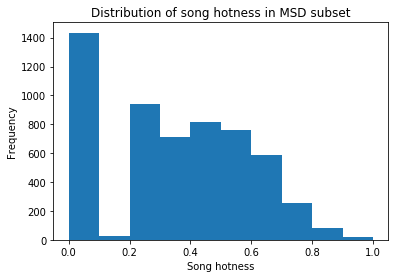

In [26]:
plt.hist(data.song_hotttnesss)
plt.title('Distribution of song hotness in MSD subset')
plt.xlabel('Song hotness')
plt.ylabel('Frequency');

In [27]:
# What percentage are zero?
print('Percentage of remaining records with zero song hotness values: {}%'.format(np.around((data['song_hotttnesss'] == 0).sum() / len(data)*100), 2))
      

Percentage of remaining records with zero song hotness values: 25.0%


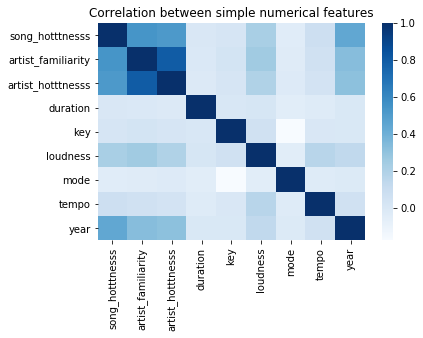

In [28]:
correlations = data.corr()
sns.heatmap(correlations, cmap = 'Blues')
plt.title('Correlation between simple numerical features');

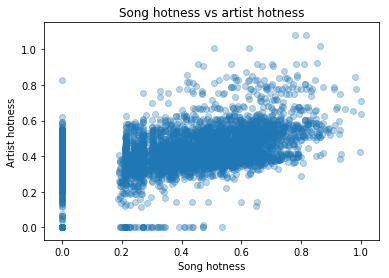

In [29]:
plt.scatter(data['song_hotttnesss'], data['artist_hotttnesss'], alpha = 0.3)
plt.title('Song hotness vs artist hotness')
plt.xlabel('Song hotness')
plt.ylabel('Artist hotness');

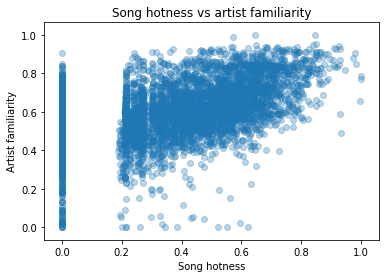

In [30]:
plt.scatter(data['song_hotttnesss'], data['artist_familiarity'], alpha = 0.3)
plt.title('Song hotness vs artist familiarity')
plt.xlabel('Song hotness')
plt.ylabel('Artist familiarity');

There is a slight positive trend of song hotness over time, which makes sense given the way that the metric is measured. We must also consider that musical tastes change over time. 

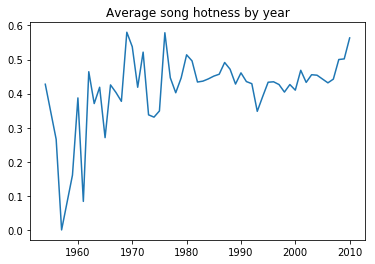

In [31]:
year_plot = data[data['year'] != 0].groupby(['year']).mean().reset_index()
plt.plot(year_plot['year'], year_plot['song_hotttnesss']);
plt.title('Average song hotness by year');

In [32]:
# Check number of years with value 0
print('Number of records with year recorded as zero: {}'.format(sum(data['year'] == 0)))

Number of records with year recorded as zero: 2584


# Merge with other datasets

The basic MSD dataset has some useful fields, but we have to explore whether we can augment this with other information. 

## Genre information

I had a look at whether we can augment the dataset with genre information. Although there is some genre information in the tags, this is mixed with other data like location and it isn't clear which is the main genre. Therefore I have linked with another dataset from Vienna University, available at: http://www.ifs.tuwien.ac.at/mir/msd/download.html


In [33]:
# Read genre info from the website
genres = pd.read_csv('http://www.ifs.tuwien.ac.at/mir/msd/partitions/msd-MAGD-genreAssignment.cls',
                       sep = '\t', 
                       header = None)

genres.columns=['track_id', 'genre_id']
genres.head()

,track_id,genre_id
0,TRAAAAK128F9318786,Pop_Rock
1,TRAAAAV128F421A322,Pop_Rock
2,TRAAAAW128F429D538,Rap
3,TRAAABD128F429CF47,Pop_Rock
4,TRAAACV128F423E09E,Pop_Rock


In [36]:
# Read genre info from the website
styles = pd.read_csv('http://www.ifs.tuwien.ac.at/mir/msd/partitions/msd-MASD-styleAssignment.cls',
                       sep = '\t', 
                       header = None)

styles.columns=['track_id', 'style']
styles.head()

,track_id,style
0,TRAAAAK128F9318786,Metal_Alternative
1,TRAAAAV128F421A322,Punk
2,TRAAAAW128F429D538,Hip_Hop_Rap
3,TRAAACV128F423E09E,Rock_Neo_Psychedelia
4,TRAAAEF128F4273421,Pop_Indie


In [37]:
# Merge on track ID
subset_augmented = subset_full.merge(genres, 
                                     how = 'left',
                                     on = 'track_id')
subset_augmented = subset_augmented.merge(styles, 
                                     how = 'left',
                                     on = 'track_id')

In [38]:
# Boo... more than half are missing - we will have to see if there are other sources that might improve things
subset_augmented['genre_id'].isna().sum(), subset_augmented['style'].isna().sum() 


(5989, 7224)

# Next steps

The simple variables here are obviously not enough to build a complex model worthy of CS109B. I suggest that the following points could be next steps - feel free to suggest others if you think they are more important.

__1. Explore the segment data (i.e. all the columns that include data as arrays such as segments_loudness_max, segments_pitches, segments_timbre).__ 
* See how we can represent and use these arrays (including time series element?). 
* Confidence of each measure should probably not be represented separately (maybe multiply it by the measure).

__2. Explore and clean categorical variables (e.g. how to use the data on similar artists, artist_terms).__ 
* Given the strong link between artist hotness and song hotness, these similarity metrics could be promising to explore. How to represent the links within the database is key.

__3. Since we have so much missing song hotness information, we may need to extract extra records from the full dataset in order to properly run the larger models.__
* Someone could explore this and come up with a better training/test set for us. The same code to read the files should work on the full dataset, and I understand that there are only around 300,000 songs with hotness data.
* It would also be good to see if we can get the danceability and energy variables back from the main dataset, since I guess these would be quite useful. 
* Alternatively, some of the papers use different popularity metrics and we could try those (as long as the TF is OK with changing the target variable). 